In [1]:
import pystac_client
import planetary_computer
import rioxarray as rio
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import shape
from shapely import Point, box
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xrspatial as xrs
plt.rcParams['font.family'] = 'DejaVu Sans Mono'

In [2]:
sdnp_geom = shape({
      "coordinates": [[
            [-0.08985080593200223,50.858667861221164],
            [-0.08985080593200223,50.79414350067211],
            [0.007405918192461058,50.79414350067211],
            [0.007405918192461058,50.858667861221164],
            [-0.08985080593200223,50.858667861221164]]],
      "type": "Polygon"})

sdnp = gpd.GeoDataFrame(geometry=[sdnp_geom], crs=4326)
prj = ccrs.epsg(sdnp.estimate_utm_crs().to_epsg())


In [ ]:
### if using bigger whole national park...
# import osmnx as ox
# sdnp = ox.features_from_place('South Downs National Park',
#                               tags={'boundary':'protected_area',
#                                     'designation':'national_park',
#                                     'name':'South Downs National Park'})

# sdnp = sdnp.loc[(sdnp['boundary'].eq('protected_area')) &
#                 (sdnp['designation'].eq('national_park')) &
#                 (sdnp['name'].eq('South Downs National Park'))].reset_index()

# prj = ccrs.epsg(sdnp.estimate_utm_crs().to_epsg())
# sdnp_geom = sdnp['geometry'][0]

### get dem

In [3]:
## get contours in aoi from copernicus global DEM hosted on planetary computer
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

search = catalog.search(collections=['cop-dem-glo-30'],
                        intersects=sdnp_geom.envelope)
items = list(search.get_items())

# if aoi crosses multiple DEM tiles stitch 'em together
if len(items) > 1:
    data = []
    for item in items:
        signed_asset = planetary_computer.sign(item.assets["data"])
        with rio.open_rasterio(signed_asset.href) as f:
            data.append(f.squeeze().drop_vars("band").rename('z'))
    dem = ((xr.merge(data))
           .rio.set_crs(4326)
           .rio.write_transform()
           .rio.clip_box(*sdnp_geom.bounds))['z']
    f.close()
else:
    signed_asset = planetary_computer.sign(items[0].assets["data"])
    dem =  (rio.open_rasterio(signed_asset.href)
            .squeeze()
            .rio.set_crs(4326)
            .rio.write_transform()
            .rio.clip_box(*sdnp_geom.bounds)).rename('z')

In [4]:
 # reproject to local utm crs
dem_prj = dem.rio.reproject(prj, resolution=30, nodata=np.nan)

# fix wonky
x,y=sdnp.to_crs(prj)['geometry'][0].exterior.coords.xy
sortx = np.sort(x)
sorty = np.sort(y)
minx, maxx=sortx[np.diff(sortx).argmax():np.diff(sortx).argmax()+2] ######## fiddly!
miny, maxy=sorty[np.diff(sorty).argmax():np.diff(sorty).argmax()+2]
dem_prj = dem_prj.rio.clip_box(minx,miny,maxx,maxy)

# dump out arrays
Z = dem_prj.values
X,Y = np.meshgrid(dem_prj.x.values, dem_prj.y.values)

# hillsahde, slope and aspect
hillshade = xrs.hillshade(dem_prj)
slope = xrs.slope(dem_prj) #.sortby(['x','y'])
aspect = xrs.aspect(dem_prj)

### flow accumulation

In [7]:
### flow accumulation
import richdem as rd

transform = dem_prj.rio.transform()
gt = (transform.c, transform.a, transform.b, transform.f, transform.d, transform.e)

Z[np.isnan(Z)] = -9999
rdem = rd.rdarray(Z, no_data=-9999)
rdem.__setattr__('geotransform', gt)

# fill 
filled = rd.FillDepressions(rdem, epsilon=True)

## accumulate
accum = rd.FlowAccumulation(filled, method='Rho8')
flow = xr.DataArray(accum,
                    dims = ['y','x'],
                    coords = {'x' : (['x'], dem_prj.x.values),
                              'y' : (['y'], dem_prj.y.values)})

inv_accum = rd.FlowAccumulation(filled*-1, method='Rho8')
inv_flow = xr.DataArray(inv_accum,
                    dims = ['y','x'],
                    coords = {'x' : (['x'], dem_prj.x.values),
                              'y' : (['y'], dem_prj.y.values)})

### plotting

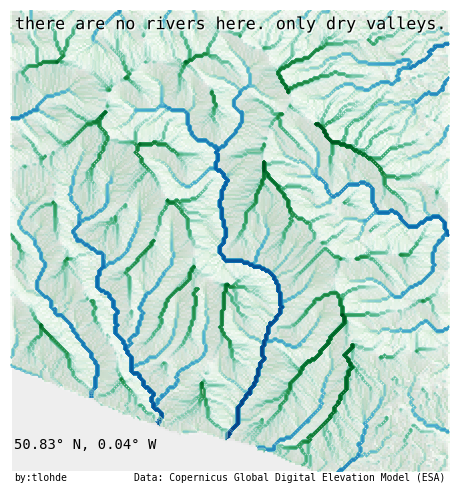

In [9]:
from matplotlib.colors import LogNorm
import matplotlib.patheffects as path_effects

fig, ax = plt.subplots(figsize=[6,6],
                       subplot_kw={'projection':prj})

(xr.where(dem_prj==0,np.nan,flow)).plot.contour(levels=500,
                                                linewidths=0.2,
                                                cmap='GnBu',
                                                norm=LogNorm(),
                                                ax=ax)

(xr.where(dem_prj==0,np.nan,inv_flow)).plot.contour(levels=500,
                                                    linewidths=0.2,
                                                    cmap='BuGn',
                                                    norm=LogNorm(),
                                                    ax=ax)

(xr.where(dem_prj==0, np.nan, inv_flow)).plot(ax=ax,
                                              cmap='BuGn', 
                                              norm=LogNorm(vmin=1,vmax=inv_flow.max()),
                                              add_colorbar=False,
                                              alpha=0.5)
(xr.where(dem_prj==0,np.nan,flow)).plot(ax=ax,
                                        cmap='GnBu',
                                        norm=LogNorm(vmin=1,vmax=flow.max()),
                                        add_colorbar=False,
                                        alpha=0.5,)

hillshade.plot(ax=ax,cmap='Greys',add_colorbar=False,alpha=0.1)

ax.set_axis_off()

ax.set_title('there are no rivers here. only dry valleys.', y=0.94,#loc='left', 
             path_effects=[path_effects.withSimplePatchShadow(shadow_rgbFace='w',
                                                              alpha=0.9,
                                                              offset=(1,-1))])

cntr = sdnp.to_crs(prj).centroid.to_crs(sdnp.crs)[0]
ax.annotate(text=(f'{cntr.y:.2f}° N, {-1*cntr.x:.2f}° W'),
            xy=(0.01,0.05),
            xycoords='axes fraction',
            ha='left',
            fontsize=10)

ax.annotate(text='Data: Copernicus Global Digital Elevation Model (ESA)',
            xy=(0.99,-0.02), 
            xycoords='axes fraction', 
            ha='right',
            fontsize=7)

ax.annotate(text='by:tlohde',
            xy=(0.01,-0.02), 
            xycoords='axes fraction',
            ha='left',
            fontsize=7)

fig.savefig('day17.png', bbox_inches='tight', dpi=300)

### quiver

In [10]:
x = slope.x.values
y = slope.y.values

u = slope / np.sin(np.deg2rad(aspect))
v = slope / np.cos(np.deg2rad(aspect))

u = np.where((u<=np.nanpercentile(u.values.flatten(),2)) |
         (u>=np.nanpercentile(u.values.flatten(),98)),
         0,
         u)
         
v = np.where((v<=np.nanpercentile(v.values.flatten(),2)) |
         (v>=np.nanpercentile(v.values.flatten(),98)),
         0,
         v)

c = aspect.values

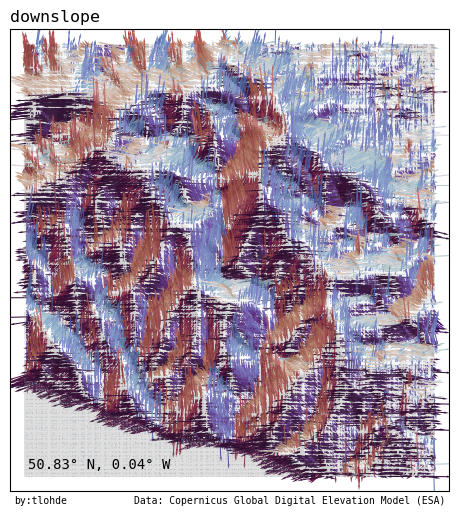

In [17]:
fig, ax = plt.subplots(figsize=[6,6],
                       subplot_kw={'projection':prj})

q = ax.quiver(x+((np.random.random(size=x.shape)-0.5) * 50),
              y+((np.random.random(size=y.shape)-0.5) * 50),
              u+((np.random.random(size=u.shape)-0.5) * 10),
              v+((np.random.random(size=v.shape)-0.5) * 10),
              c+((np.random.random(size=c.shape)-0.5) * 35),
              cmap='twilight',
              scale_units='xy',
              scale=0.2,
              headwidth=2)

hillshade.plot(ax=ax,cmap='Greys',add_colorbar=False,alpha=0.2)

ax.set_title('')
ax.set_title('downslope', loc='left')

cntr = sdnp.to_crs(prj).centroid.to_crs(sdnp.crs)[0]
ax.annotate(text=(f'{cntr.y:.2f}° N, {-1*cntr.x:.2f}° W'),
            xy=(0.04,0.05),
            xycoords='axes fraction',
            ha='left',
            fontsize=10)

ax.annotate(text='Data: Copernicus Global Digital Elevation Model (ESA)',
            xy=(0.99,-0.025), 
            xycoords='axes fraction', 
            ha='right',
            fontsize=7)

ax.annotate(text='by:tlohde',
            xy=(0.01,-0.025), 
            xycoords='axes fraction',
            ha='left',
            fontsize=7)

xlim = ax.get_xlim()
ylim = ax.get_ylim()

ax.set_xlim(xlim[0]-200, xlim[1]+200)
ax.set_ylim(ylim[0]-200, ylim[1]+200)

fig.savefig('day17_b.png', bbox_inches='tight', dpi=300)

### for ridge stuff

In [ ]:
res = hillshade.rio.resolution()[0]
outer_rad = res * 10
inner_rad = res * 3

kern = xrs.convolution.annulus_kernel(res, res, outer_rad, inner_rad)
tpi = (dem_prj - xrs.convolution._convolve_2d_numpy(dem_prj.values, kern))

ridges = (tpi<np.nanpercentile(tpi.values.flat, 24))

### polygonize
flat_ridges = ridges.values.flatten()
X,Y = np.meshgrid(ridges.x.values, ridges.y.values)

ridge_points = [Point(p) for p in zip(X.flat[flat_ridges], Y.flat[flat_ridges])]
rp = gpd.GeoDataFrame(geometry=ridge_points,crs=prj)

rp['geometry'] = rp['geometry'].apply(lambda p: p.buffer(res))

ridge_polygons = rp.dissolve().explode(index_parts=True)['geometry']
ridge_polygons = ridge_polygons[0].tolist()

def get_centreline_points(geom, threshold):
    from shapely.ops import voronoi_diagram
    _v = voronoi_diagram(geom)
    _x = [x for x,y in [q.exterior.coords.xy for q in _v.geoms]]
    _y = [y for x,y in [q.exterior.coords.xy for q in _v.geoms]]
    _p = gpd.GeoSeries([Point(p) for p in zip([val for sublist in _x for val in sublist],
                                                [val for sublist in _y for val in sublist])],
                        crs=prj)
    _p = _p.loc[_p.intersects(geom)]
    _d = geom.exterior.distance(_p)
    return _p.loc[_d>threshold].reset_index(drop=True)

In [ ]:
ridge_tops = pd.concat([get_centreline_points(p,100) for p in ridge_polygons]).reset_index(drop=True)
u = slope / np.cos(np.deg2rad(aspect))
v = slope / np.sin(np.deg2rad(aspect))

fig, ax = plt.subplots()

dem_prj.plot(ax=ax, cmap='Greys')

ax.streamplot(
    x=hillshade.x.values,
    y=hillshade.y.values,
    u=u, v=v,
    density=1,
    start_points = list(zip(ridge_tops.x,
                            ridge_tops.y))
)

### clipping to aoi

In [ ]:
from geocube.api.core import make_geocube
sdnp_raster = (make_geocube(sdnp.to_crs(prj),
                            measurements=['osmid'],
                            resolution=(30,30),
                            output_crs=prj)['osmid']
               .rio.reproject_match(dem_prj)
)


flow = xr.where(flow==-9999,np.nan,flow)#
flow = xr.where(sdnp_raster==sdnp['osmid'][0], flow, np.nan)